# Decision Analysis (influence diagram) with Python `pyAgrum` using Evans, 1997

HOME: <https://di4health.github.io>

NOTE: This notebook was created by Antropic's Claude Code. Here was my workflow:

1. I asked Claude Code to replicate Julia's `Decision Programming.jl` using Python's [pyAgrum package](https://pyagrum.gitlab.io/) for probabilistic graphical modeling, including Bayesian decision networks (influence diagrams). 
2. I used Anaconda Python 3.13.5 in VS Code Jupyter notebook. I asked Google Gemini to correct the errors (which were minor). 
3. I asked Claude Code to review corrected notebook and to find improvements for conciseness and clarity. 

The final Python Jupyter notebook is below is unedited for your review. Your feedback and questions are welcome. 

---

Tomás Aragón

This notebook replicates the Evans 1997 migraine cost-effectiveness analysis using Python's [pyAgrum](https://pyagrum.readthedocs.io/) library for influence diagrams. It parallels the Julia `DecisionProgramming.jl` analysis.

Sources:
- Briggs, A. H., K. Claxton, and M. Sculpher. *Decision Modelling for Health Economic Evaluation.* Oxford, 2006.
- Evans, K. W., et al. *PharmacoEconomics* 12(5): 565–77 (1997).

## Conceptual comparison

| Package | Language | Approach |
|---------|----------|----------|
| `rdecision` | R | Decision tree (rollback) |
| `DecisionProgramming.jl` | Julia | Influence diagram (MILP) |
| **`pyAgrum`** (this notebook) | **Python** | **Influence diagram (Shafer-Shenoy / LIMID)** |

## Strategy

pyAgrum, like DecisionProgramming.jl, sums all utility nodes into a single maximum expected utility (MEU). For CEA we need E[Cost] and E[Utility] separately, so we build **two diagrams**: one with the utility value node, one with the cost value nodes.

In [1]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb
print(f"pyAgrum version: {gum.__version__}")

pyAgrum version: 2.3.2


## 1. Model parameters

Same 14 parameters from Evans 1997: 4 costs, 4 utilities, 6 probabilities.

In [2]:
# Costs (Canadian dollars)
c_sumatriptan = 16.10
c_caffeine    = 1.32
c_ed          = 63.16
c_hospital    = 1093.0

# Utilities (quality-of-life weights)
u_relief_norec = 1.0
u_relief_rec   = 0.9
u_norel_endure = -0.30
u_norel_ed     = 0.1

# Probabilities
p_relief_suma  = 0.558     # P(relief | sumatriptan)
p_relief_caff  = 0.379     # P(relief | caffeine)
p_norec_suma   = 0.594     # P(no recurrence | relief, sumatriptan)
p_norec_caff   = 0.703     # P(no recurrence | relief, caffeine)
p_endures      = 0.92      # P(endures | no relief)
p_relief_ed    = 0.998     # P(relief | ED visit)

## 2. Shared diagram structure

```
D (decision) → R (relief) → N (recurrence, also ← D)
                           → E (endures/ED) → H (ED outcome)
```
Nodes N, E, H include an "NA" state for structurally impossible branches (asymmetric tree encoded in a symmetric influence diagram).

In [3]:
def build_diagram():
    """Create InfluenceDiagram with decision and chance nodes (no value nodes)."""
    diag = gum.InfluenceDiagram()

    diag.addDecisionNode(gum.LabelizedVariable("D", "Treatment",       ["D1", "D2"]))
    diag.addChanceNode(  gum.LabelizedVariable("R", "Relief",          ["R1", "R2"]))
    diag.addChanceNode(  gum.LabelizedVariable("N", "Recurrence",      ["N1", "N2", "NA"]))
    diag.addChanceNode(  gum.LabelizedVariable("E", "NoReliefOutcome", ["E1", "E2", "NA"]))
    diag.addChanceNode(  gum.LabelizedVariable("H", "EDOutcome",       ["H1", "H2", "NA"]))

    for tail, head in [("D","R"), ("D","N"), ("R","N"), ("R","E"), ("E","H")]:
        diag.addArc(tail, head)

    # --- Fill CPTs ---
    # P(R | D)
    diag.cpt("R")[{"D": "D1"}] = [p_relief_suma, 1 - p_relief_suma]
    diag.cpt("R")[{"D": "D2"}] = [p_relief_caff, 1 - p_relief_caff]

    # P(N | D, R) — N1=no recurrence, N2=recurrence, NA when no relief
    diag.cpt("N")[{"D": "D1", "R": "R1"}] = [p_norec_suma, 1 - p_norec_suma, 0.0]
    diag.cpt("N")[{"D": "D1", "R": "R2"}] = [0.0, 0.0, 1.0]
    diag.cpt("N")[{"D": "D2", "R": "R1"}] = [p_norec_caff, 1 - p_norec_caff, 0.0]
    diag.cpt("N")[{"D": "D2", "R": "R2"}] = [0.0, 0.0, 1.0]

    # P(E | R) — E1=endures, E2=ED, NA when relief
    diag.cpt("E")[{"R": "R1"}] = [0.0, 0.0, 1.0]
    diag.cpt("E")[{"R": "R2"}] = [p_endures, 1 - p_endures, 0.0]

    # P(H | E) — H1=ED relief, H2=hospital, NA otherwise
    diag.cpt("H")[{"E": "E1"}] = [0.0, 0.0, 1.0]
    diag.cpt("H")[{"E": "E2"}] = [p_relief_ed, 1 - p_relief_ed, 0.0]
    diag.cpt("H")[{"E": "NA"}] = [0.0, 0.0, 1.0]

    return diag

print("build_diagram() defined.")

build_diagram() defined.


## 3. Diagram 1: Utility

A single utility node U(D, N, E, H) maps each of the 10 reachable leaf states (A–J) to Evans 1997 quality-of-life weights. Unreachable combinations default to 0.

Utility diagram built.


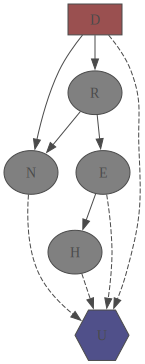

In [4]:
diag_u = build_diagram()

diag_u.addUtilityNode(gum.LabelizedVariable("U", "Utility", 1))
for parent in ["D", "N", "E", "H"]:
    diag_u.addArc(parent, "U")

# Utility values — identical for both arms (symmetric by treatment)
# Leaf:  A/F          B/G          C/H             D/I          E/J
leaves = [
    ({"N": "N1", "E": "NA", "H": "NA"}, u_relief_norec),    # A/F: relief, no recurrence
    ({"N": "N2", "E": "NA", "H": "NA"}, u_relief_rec),      # B/G: relief, recurrence
    ({"N": "NA", "E": "E1", "H": "NA"}, u_norel_endure),    # C/H: no relief, endures
    ({"N": "NA", "E": "E2", "H": "H1"}, u_norel_ed),       # D/I: no relief, ED relief
    ({"N": "NA", "E": "E2", "H": "H2"}, u_norel_endure),   # E/J: no relief, hospitalized
]
for d_label in ["D1", "D2"]:
    for state, util in leaves:
        diag_u.utility("U")[{"D": d_label, **state}] = util

print("Utility diagram built.")
gnb.showInfluenceDiagram(diag_u)

## 4. Diagram 2: Cost

Four cost nodes: C1(D) initial drug, C2(D,N) 2nd dose, C3(E) ED visit, C4(H) hospitalization. pyAgrum initializes utility tables to 0, so only non-zero entries need setting.

Cost diagram built.


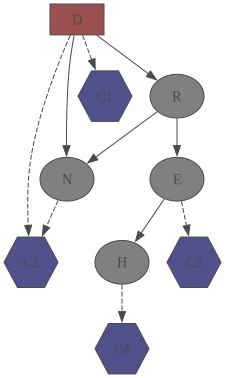

In [5]:
diag_c = build_diagram()

for name in ["C1", "C2", "C3", "C4"]:
    diag_c.addUtilityNode(gum.LabelizedVariable(name, name, 1))
diag_c.addArc("D", "C1")
diag_c.addArc("D", "C2");  diag_c.addArc("N", "C2")
diag_c.addArc("E", "C3")
diag_c.addArc("H", "C4")

# Only set non-zero costs
diag_c.utility("C1")[{"D": "D1"}] = c_sumatriptan
diag_c.utility("C1")[{"D": "D2"}] = c_caffeine

diag_c.utility("C2")[{"D": "D1", "N": "N2"}] = c_sumatriptan   # 2nd dose on recurrence
diag_c.utility("C2")[{"D": "D2", "N": "N2"}] = c_caffeine

diag_c.utility("C3")[{"E": "E2"}] = c_ed
diag_c.utility("C4")[{"H": "H2"}] = c_hospital

print("Cost diagram built.")
gnb.showInfluenceDiagram(diag_c)

## 5. Inference

We use `ShaferShenoyLIMIDInference`, fix D with `addEvidence`, and read MEU — analogous to the `@constraint` approach in DecisionProgramming.jl.

In [6]:
def expected_value(diag, decision_label):
    """Run LIMID inference with D fixed; return MEU."""
    ie = gum.ShaferShenoyLIMIDInference(diag)
    ie.addEvidence("D", decision_label)
    ie.addNoForgettingAssumption(["D"])
    ie.makeInference()
    return ie.MEU()["mean"]

EU_D1 = expected_value(diag_u, "D1")   # E[Utility | Sumatriptan]
EU_D2 = expected_value(diag_u, "D2")   # E[Utility | Caffeine]
EC_D1 = expected_value(diag_c, "D1")   # E[Cost | Sumatriptan]
EC_D2 = expected_value(diag_c, "D2")   # E[Cost | Caffeine]

print(f"E[U|Sumatriptan] = {EU_D1:.7f}")
print(f"E[U|Caffeine]    = {EU_D2:.7f}")
print(f"E[C|Sumatriptan] = {EC_D1:.4f}")
print(f"E[C|Caffeine]    = {EC_D2:.4f}")

E[U|Sumatriptan] = 0.4168609
E[U|Caffeine]    = 0.2012760
E[C|Sumatriptan] = 22.0581
E[C|Caffeine]    = 4.7150


## 6. Cost-effectiveness analysis

In [7]:
delta_C = EC_D1 - EC_D2
delta_U = EU_D1 - EU_D2
ICER = (delta_C / delta_U) * 365   # annualize: 24h time horizon

print("=== Cost-Effectiveness Analysis (pyAgrum) ===")
print(f"{'Strategy':<20} {'E[Cost]':>10} {'E[Utility]':>12}")
print(f"{'Caffeine/Ergot':<20} {EC_D2:10.4f} {EU_D2:12.7f}")
print(f"{'Sumatriptan':<20} {EC_D1:10.4f} {EU_D1:12.7f}")
print()
print(f"Incremental Cost:    {delta_C:.4f}")
print(f"Incremental Utility: {delta_U:.7f}")
print(f"ICER: ${ICER:.0f} Can/QALY")

=== Cost-Effectiveness Analysis (pyAgrum) ===
Strategy                E[Cost]   E[Utility]
Caffeine/Ergot           4.7150    0.2012760
Sumatriptan             22.0581    0.4168609

Incremental Cost:    17.3431
Incremental Utility: 0.2155850
ICER: $29363 Can/QALY


## 7. Comparison with reference values

In [8]:
# Analytical reference from DecisionProgramming.jl / R rdecision
ref = dict(EC_D1=22.058057, EU_D1=0.4168609,
           EC_D2=4.714972,  EU_D2=0.2012760, ICER=29363.0)

print("=== pyAgrum vs Reference (DecisionProgramming.jl / rdecision) ===")
print(f"{'':24} {'pyAgrum':>10} {'Reference':>10} {'Diff':>10}")
print(f"{'E[C|Sumatriptan]':<24} {EC_D1:10.4f} {ref['EC_D1']:10.4f} {EC_D1 - ref['EC_D1']:+10.4f}")
print(f"{'E[U|Sumatriptan]':<24} {EU_D1:10.7f} {ref['EU_D1']:10.7f} {EU_D1 - ref['EU_D1']:+10.7f}")
print(f"{'E[C|Caffeine]':<24} {EC_D2:10.4f} {ref['EC_D2']:10.4f} {EC_D2 - ref['EC_D2']:+10.4f}")
print(f"{'E[U|Caffeine]':<24} {EU_D2:10.7f} {ref['EU_D2']:10.7f} {EU_D2 - ref['EU_D2']:+10.7f}")
print(f"{'ICER':<24} {ICER:10.0f} {ref['ICER']:10.0f} {ICER - ref['ICER']:+10.0f}")

=== pyAgrum vs Reference (DecisionProgramming.jl / rdecision) ===
                            pyAgrum  Reference       Diff
E[C|Sumatriptan]            22.0581    22.0581    +0.0000
E[U|Sumatriptan]          0.4168609  0.4168609 +0.0000000
E[C|Caffeine]                4.7150     4.7150    +0.0000
E[U|Caffeine]             0.2012760  0.2012760 -0.0000000
ICER                          29363      29363         +0


## Notes on pyAgrum vs DecisionProgramming.jl

| Feature | DecisionProgramming.jl | pyAgrum |
|---------|----------------------|----------|
| Inference | MILP optimization (HiGHS) | Shafer-Shenoy message passing |
| Fix decision | `@constraint` on binary variables | `addEvidence("D", "D1")` |
| Utility nodes | `UtilityMatrix` with string indexing | `diag.utility("U")[{...}]` dict indexing |
| CPTs | `ProbabilityMatrix` with string indexing | `diag.cpt("R")[{...}]` array/dict indexing |
| CEA approach | Two separate diagrams | Two separate diagrams |
| Visualization | Limited | Rich (`gnb.showInfluenceDiagram`) |
| Installation | Julia packages | `pip install pyAgrum` |